In [1]:
#### How does changing the beam jitter affect the QM limited Sensitivity?

In [5]:
%matplotlib inline
import pykat
import pykat.optics.ABCD as abcd
import pylab as pl
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

### My functions
from kat_commands import *
from MMT import *
from cav_commands import *
from load_kat_data import *

In [2]:
### The kat file is an aLIGO IFO setup with a FC.
katfile = "aLIGO_IFO_AWC_tuning_DCoff_maxtem4_modified.kat" 

In [3]:
darm_commands1 = """
tf sus 1 0 p $mech_fres $mech_Q
const mech_fres 1  # Approx. resonance frequency
const mech_Q    1M # Guess for suspension Q factor
# Differentially modulate the strain in the arms
fsig darm  LXarm 1 0 1
fsig darm2 LYarm 1 180 1
qnoisedS NSR_with_RP 1 $fs nOMC_AROC_trans
xaxis darm f log 5 10k 100
yaxis lin re:im
retrace off
"""

beam_params = """
bp PSLinx x q n0
bp PSLiny y q n0
"""

In [7]:
#load the original kat file (ie Perfect Modematching) as a reference
basekat = pykat.finesse.kat() 
basekat.loadKatFile(katfile)
basekat.parseCommands(darm_commands1)
basekat.parseCommands(pds)
basekat.parseCommands(beam_params)
basekat.parseCommands(add_squeezing)
basekat.parseCommands("maxtem "+str(2))
basekat.undumpNodes() #undump the vacuum nodes to get the right quantum noise
kat=basekat.deepcopy() #copy kat code
kat.verbose = False

freq = []

out_perfect_mm = kat.run()
freq.append(out_perfect_mm.x)

Parsing `dbs OPP nOPb nOPc nOPd nOPz` into pykat object not implemented yet, added as extra line.


In [8]:
### Check the orginal and add 5% mode mistmatch
PSL_qx_orig = out_perfect_mm['PSLinx'][0]
PSL_qy_orig = out_perfect_mm['PSLiny'][0]

PSL_qx_new = PSL_qx_orig + 7.675j
PSL_qy_new = PSL_qx_orig + 7.681j

overlap_check_x = pykat.optics.gaussian_beams.gauss_param.overlap(PSL_qx_orig,PSL_qx_new)
overlap_check_y = pykat.optics.gaussian_beams.gauss_param.overlap(PSL_qy_orig,PSL_qy_new)

print("Overlap_x is "+str(overlap_check_x))
print("Overlap_x is "+str(overlap_check_y))

Overlap_x is 0.950078012954
Overlap_x is 0.950072302699


In [9]:
range_min =  1
range_max = 10

darm = []
overlap = []
for i in range(range_min,range_max,1):
    max_offset_x = 10.675j
    max_offset_y = 10.681j
    
    offset_x = max_offset_x/float(i)
    offset_y = max_offset_y/float(i)

    PSL_qx_new = PSL_qx_orig + offset_x
    PSL_qy_new = PSL_qy_orig + offset_y
    
    basekat = pykat.finesse.kat() 
    basekat.loadKatFile(katfile)
    basekat.parseCommands(darm_commands1)
    basekat.parseCommands(beam_params)
    basekat.parseCommands(add_squeezing)
    basekat.parseCommands("maxtem "+str(2))
    basekat.parseCommands("gauss* inqx L0 n0 "+str(PSL_qx_new.real) + " " + str(PSL_qx_new.imag) + " " + \
    str(PSL_qy_new.real) + " " + str(PSL_qy_new.imag) )
    
    basekat.undumpNodes() #undump the vacuum nodes to get the right quantum noise
    kat=basekat.deepcopy() #copy kat code
    kat.verbose = False

    out = kat.run()
    
    ovl = pykat.optics.gaussian_beams.gauss_param.overlap(PSL_qx_orig,out['PSLinx'][0])

    
    print(ovl)
    overlap.append(ovl)
    darm.append(out['NSR_with_RP'])

Parsing `dbs OPP nOPb nOPc nOPd nOPz` into pykat object not implemented yet, added as extra line.
0.918314673312
Parsing `dbs OPP nOPb nOPc nOPd nOPz` into pykat object not implemented yet, added as extra line.
0.972201309594
Parsing `dbs OPP nOPb nOPc nOPd nOPz` into pykat object not implemented yet, added as extra line.
0.986148136101
Parsing `dbs OPP nOPb nOPc nOPd nOPz` into pykat object not implemented yet, added as extra line.
0.991728749272
Parsing `dbs OPP nOPb nOPc nOPd nOPz` into pykat object not implemented yet, added as extra line.
0.994508441385
Parsing `dbs OPP nOPb nOPc nOPd nOPz` into pykat object not implemented yet, added as extra line.
0.996090441323
Parsing `dbs OPP nOPb nOPc nOPd nOPz` into pykat object not implemented yet, added as extra line.
0.997075662069
Parsing `dbs OPP nOPb nOPc nOPd nOPz` into pykat object not implemented yet, added as extra line.
0.997730475114
Parsing `dbs OPP nOPb nOPc nOPd nOPz` into pykat object not implemented yet, added as extra line

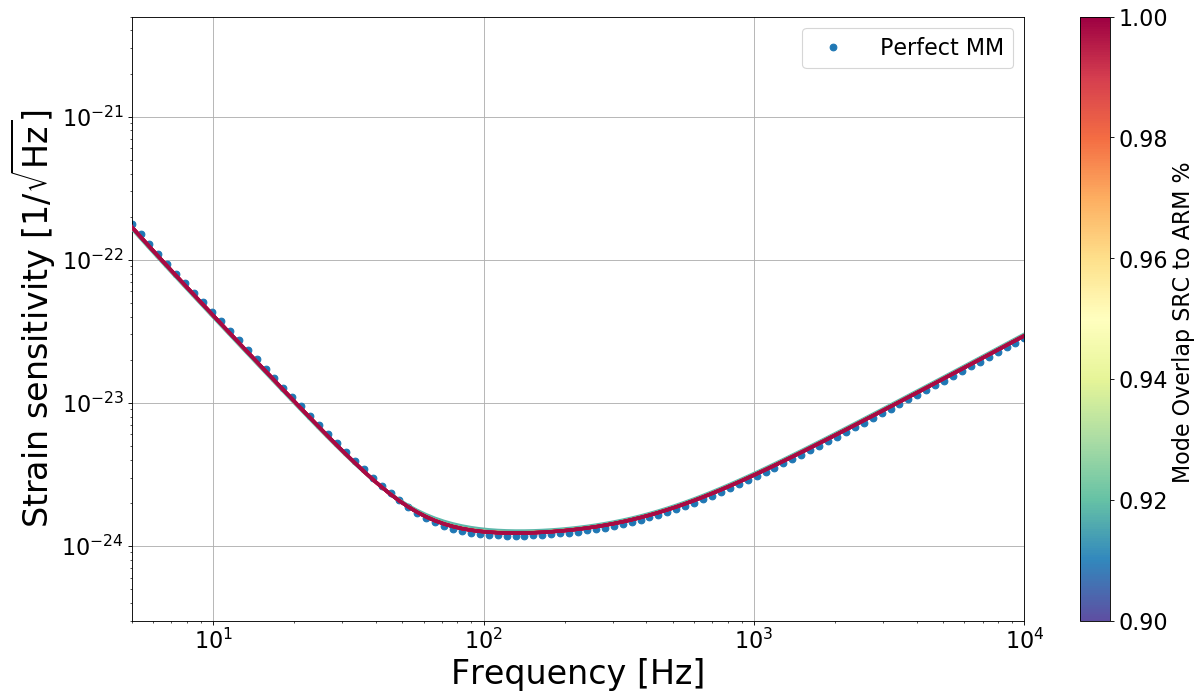

In [10]:
pl.figure(figsize=(18, 10), dpi=80)

cm = pl.cm.Spectral_r
norm = matplotlib.colors.Normalize(0.90, 1.0)

s_m = matplotlib.cm.ScalarMappable(cmap=cm, norm=norm)
s_m.set_array([])


for i in range(len(darm)):
    c = c = s_m.to_rgba(overlap[i])
    pl.subplot(111)
    pl.loglog(freq[0], np.real(darm[i]),linewidth=3,zorder=1000, color = c,)

pl.loglog(out_perfect_mm.x, np.real(out_perfect_mm['NSR_with_RP']),'o',label=' Perfect MM')

#pl.title("ARMtoOMC::QN-Limited Varying SR3 w/10Db Sqz",fontsize=30)
pl.xlim(freq[0].min(),freq[0].max())
pl.ylim(3e-25,5e-21)
pl.xlabel("Frequency [Hz]",fontsize=30)
pl.ylabel("Strain sensitivity [$1/\\sqrt{\mathrm{Hz}}$]",fontsize=30)

###Main plot formatting
pl.tick_params(labelsize=20)
pl.grid(True, zorder=-1)
pl.legend(fontsize=20)

###Colorbar formatting
cb = pl.colorbar(s_m)
cb.set_label("Mode Overlap SRC to ARM % ", fontsize = 20)
cb.ax.tick_params(labelsize=20) 
cb.update_ticks()

pl.savefig("OMCtoARM_ht_varyingSR3_w10dbSqz_MMparam.png")

pl.show()

C:\Users\tvo88\Anaconda3\lib\site-packages\numpy\core\numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


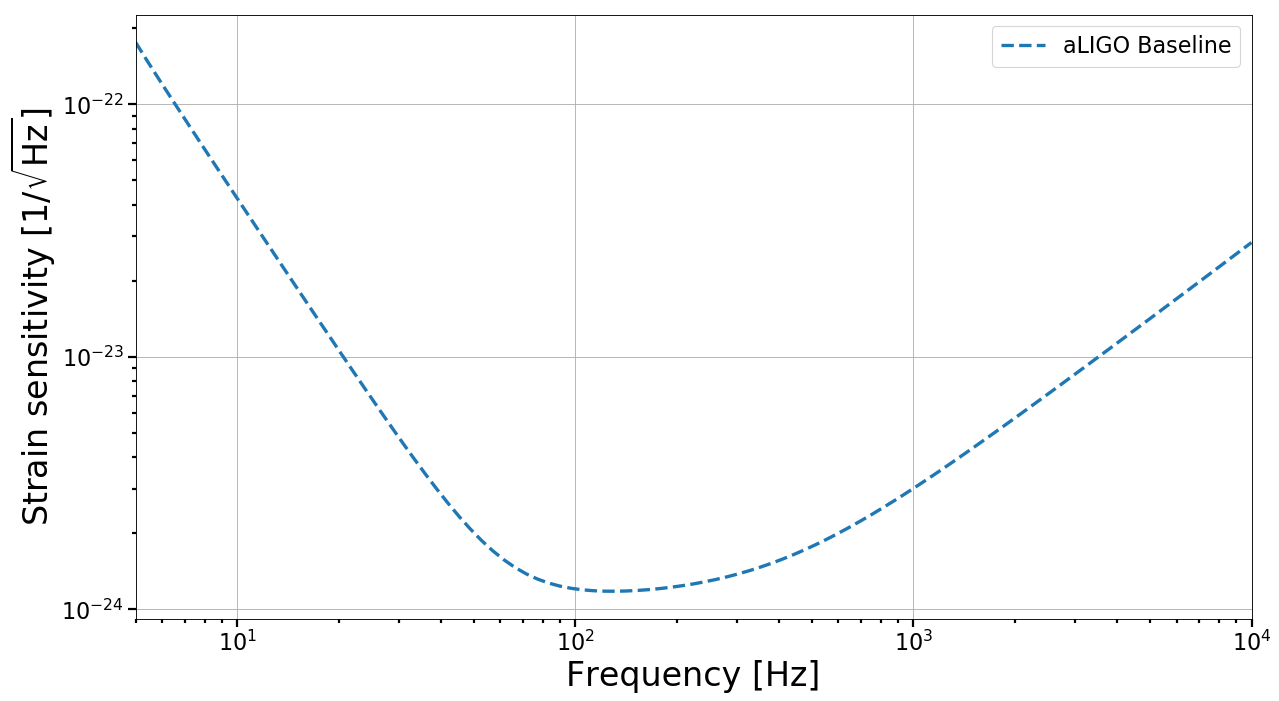

In [11]:
pl.figure(figsize=(18, 10), dpi=80)
pl.subplot(111)

pl.loglog(freq[0], out_perfect_mm['NSR_with_RP'],'--',linewidth=3, label='aLIGO Baseline')


###Main plot formatting
pl.xlim(freq[0].min(),freq[0].max())

pl.xlabel("Frequency [Hz]",fontsize=30)
pl.ylabel("Strain sensitivity [$1/\\sqrt{\mathrm{Hz}}$]",fontsize=30)

pl.tick_params(labelsize=20)
pl.tick_params(which='both', width=2)
pl.tick_params(which='major', length=7)
pl.tick_params(which='minor', length=4)
pl.grid(True, zorder=-1)
pl.legend(fontsize=20)

pl.show()

BasePyKatException: No output by the name 'signal' found in the output

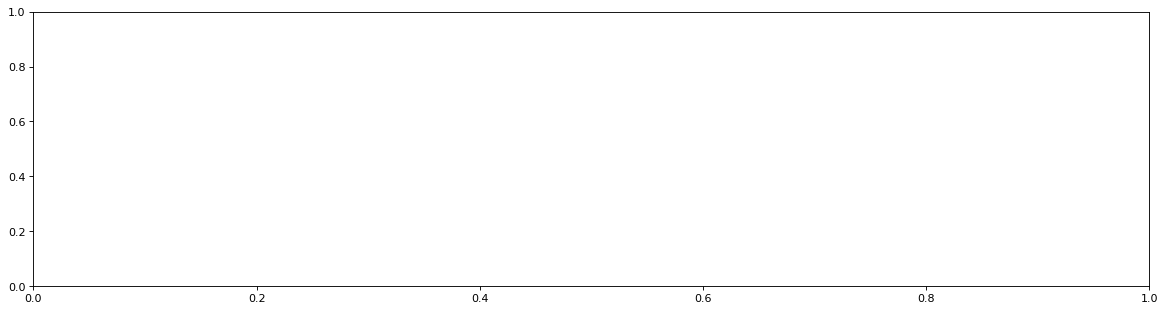

In [12]:
pl.figure(figsize=(18, 10), dpi=80)


pl.subplot(211)

pl.loglog(freq[0], np.absolute(out_perfect_mm['signal']),linewidth=3, label='Perfect MM w/ Sqz')


###Main plot formatting
pl.xlim(freq[0].min(),freq[0].max())
pl.tick_params(labelsize=20)
pl.tick_params(which='both', width=2)
pl.tick_params(which='major', length=7)
pl.tick_params(which='minor', length=4)
pl.grid(True, zorder=-1)
pl.ylabel("Signal Abs",fontsize=30)
pl.legend(fontsize=15)


pl.subplot(212)
pl.semilogx(freq[0], np.angle(out_perfect_mm['signal'],deg=True),linewidth=3, label='Signal')

pl.xlim(freq[0].min(),freq[0].max())
pl.xlabel("Frequency [Hz]",fontsize=30)
pl.ylabel("Phase(Degrees)",fontsize=30)

###Main plot formatting
pl.tick_params(labelsize=20)
pl.tick_params(which='both', width=2)
pl.tick_params(which='major', length=7)
pl.tick_params(which='minor', length=4)
pl.grid(True, zorder=-1)

pl.show()